# Implementing Stochastic Gradient Descent

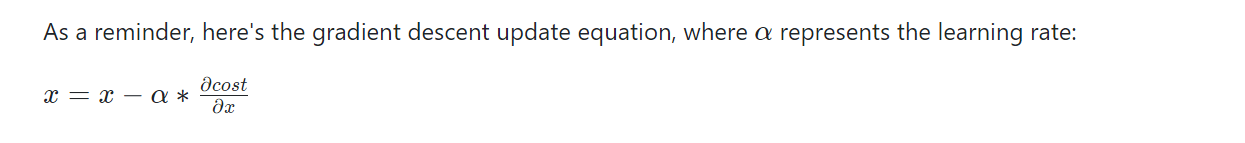

In [1]:
import numpy as np


class Node(object):
    """
    Base class for nodes in the network.

    Arguments:

        `inbound_nodes`: A list of nodes with edges into this node.
    """
    def __init__(self, inbound_nodes=[]):
        """
        Node's constructor (runs when the object is instantiated). Sets
        properties that all nodes need.
        """
        # A list of nodes with edges into this node.
        self.inbound_nodes = inbound_nodes
        # The eventual value of this node. Set by running
        # the forward() method.
        self.value = None
        # A list of nodes that this node outputs to.
        self.outbound_nodes = []
        # New property! Keys are the inputs to this node and
        # their values are the partials of this node with
        # respect to that input.
        self.gradients = {}
        # Sets this node as an outbound node for all of
        # this node's inputs.
        for node in inbound_nodes:
            node.outbound_nodes.append(self)

    def forward(self):
        """
        Every node that uses this class as a base class will
        need to define its own `forward` method.
        """
        raise NotImplementedError

    def backward(self):
        """
        Every node that uses this class as a base class will
        need to define its own `backward` method.
        """
        raise NotImplementedError


class Input(Node):
    """
    A generic input into the network.
    """
    def __init__(self):
        # The base class constructor has to run to set all
        # the properties here.
        #
        # The most important property on an Input is value.
        # self.value is set during `topological_sort` later.
        Node.__init__(self)

    def forward(self):
        # Do nothing because nothing is calculated.
        pass

    def backward(self):
        # An Input node has no inputs so the gradient (derivative)
        # is zero.
        # The key, `self`, is reference to this object.
        self.gradients = {self: 0}
        # Weights and bias may be inputs, so you need to sum
        # the gradient from output gradients.
        for n in self.outbound_nodes:
            self.gradients[self] += n.gradients[self]

class Linear(Node):
    """
    Represents a node that performs a linear transform.
    """
    def __init__(self, X, W, b):
        # The base class (Node) constructor. Weights and bias
        # are treated like inbound nodes.
        Node.__init__(self, [X, W, b])

    def forward(self):
        """
        Performs the math behind a linear transform.
        """
        X = self.inbound_nodes[0].value
        W = self.inbound_nodes[1].value
        b = self.inbound_nodes[2].value
        self.value = np.dot(X, W) + b

    def backward(self):
        """
        Calculates the gradient based on the output values.
        """
        # Initialize a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}
        # Cycle through the outputs. The gradient will change depending
        # on each output, so the gradients are summed over all outputs.
        for n in self.outbound_nodes:
            # Get the partial of the cost with respect to this node.
            grad_cost = n.gradients[self]
            # Set the partial of the loss with respect to this node's inputs.
            self.gradients[self.inbound_nodes[0]] += np.dot(grad_cost, self.inbound_nodes[1].value.T)
            # Set the partial of the loss with respect to this node's weights.
            self.gradients[self.inbound_nodes[1]] += np.dot(self.inbound_nodes[0].value.T, grad_cost)
            # Set the partial of the loss with respect to this node's bias.
            self.gradients[self.inbound_nodes[2]] += np.sum(grad_cost, axis=0, keepdims=False)


class Sigmoid(Node):
    """
    Represents a node that performs the sigmoid activation function.
    """
    def __init__(self, node):
        # The base class constructor.
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        """
        This method is separate from `forward` because it
        will be used with `backward` as well.

        `x`: A numpy array-like object.
        """
        return 1. / (1. + np.exp(-x))

    def forward(self):
        """
        Perform the sigmoid function and set the value.
        """
        input_value = self.inbound_nodes[0].value
        self.value = self._sigmoid(input_value)

    def backward(self):
        """
        Calculates the gradient using the derivative of
        the sigmoid function.
        """
        # Initialize the gradients to 0.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}
        # Sum the partial with respect to the input over all the outputs.
        for n in self.outbound_nodes:
            grad_cost = n.gradients[self]
            sigmoid = self.value
            self.gradients[self.inbound_nodes[0]] += sigmoid * (1 - sigmoid) * grad_cost


class MSE(Node):
    def __init__(self, y, a):
        """
        The mean squared error cost function.
        Should be used as the last node for a network.
        """
        # Call the base class' constructor.
        Node.__init__(self, [y, a])

    def forward(self):
        """
        Calculates the mean squared error.
        """
        # NOTE: We reshape these to avoid possible matrix/vector broadcast
        # errors.
        #
        # For example, if we subtract an array of shape (3,) from an array of shape
        # (3,1) we get an array of shape(3,3) as the result when we want
        # an array of shape (3,1) instead.
        #
        # Making both arrays (3,1) insures the result is (3,1) and does
        # an elementwise subtraction as expected.
        y = self.inbound_nodes[0].value.reshape(-1, 1)
        a = self.inbound_nodes[1].value.reshape(-1, 1)

        self.m = self.inbound_nodes[0].value.shape[0]
        # Save the computed output for backward.
        self.diff = y - a
        self.value = np.mean(self.diff**2)

    def backward(self):
        """
        Calculates the gradient of the cost.
        """
        self.gradients[self.inbound_nodes[0]] = (2 / self.m) * self.diff
        self.gradients[self.inbound_nodes[1]] = (-2 / self.m) * self.diff


def topological_sort(feed_dict):
    """
    Sort the nodes in topological order using Kahn's Algorithm.

    `feed_dict`: A dictionary where the key is a `Input` Node and the value is the respective value feed to that Node.

    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outbound_nodes:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]

        L.append(n)
        for m in n.outbound_nodes:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def forward_and_backward(graph):
    """
    Performs a forward pass and a backward pass through a list of sorted Nodes.

    Arguments:

        `graph`: The result of calling `topological_sort`.
    """
    # Forward pass
    for n in graph:
        n.forward()

    # Backward pass
    # see: https://docs.python.org/2.3/whatsnew/section-slices.html
    for n in graph[::-1]:
        n.backward()


def sgd_update(trainables, learning_rate=1e-2):
    """
    Updates the value of each trainable with SGD.

    Arguments:

        `trainables`: A list of `Input` Nodes representing weights/biases.
        `learning_rate`: The learning rate.
    """
    # Performs SGD
    #
    # Loop over the trainables
    for t in trainables:
        # Change the trainable's value by subtracting the learning rate
        # multiplied by the partial of the cost with respect to this
        # trainable.
        partial = t.gradients[t]
        t.value -= learning_rate * partial


In [2]:
"""
Check out the new network architecture and dataset!

Notice that the weights and biases are
generated randomly.

we can play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 10
# Total number of examples
m = X_.shape[0]
batch_size = 11
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        forward_and_backward(graph)

        # Step 3
        sgd_update(trainables)

        loss += graph[-1].value

    print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))


Total number of examples = 506
Epoch: 1, Loss: 140.212
Epoch: 2, Loss: 43.212
Epoch: 3, Loss: 28.029
Epoch: 4, Loss: 32.852
Epoch: 5, Loss: 24.541
Epoch: 6, Loss: 25.392
Epoch: 7, Loss: 16.076
Epoch: 8, Loss: 16.625
Epoch: 9, Loss: 16.084
Epoch: 10, Loss: 15.674


In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()

X_ = data['data']
y_ = data['target']

#df = pd.DataFrame(X_,y_, columns=[1,2,3,4,5,6,7,8,9,10,11,12,13])

#print(df)

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)


In [4]:
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)
X_.shape[1]

13

In [5]:
car = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}

car.values()



dict_values(['Ford', 'Mustang', 1964])